## Naive Bayes

Our task for today will be to classify emails as spam or not spam. We sill use the Enron Email Dataset. The dataset contains email text along with a label of whether that text was spam or not.

First, let's load the dataset, and look at an example too!

In [2]:
%matplotlib inline
import lib.download
lib.download.run()

import lib.dataset

print()
print(">>> HAM EMAIL:")
print("=" * 72)
print(lib.dataset.RAW_DATA['ham_emails'][5].text_content())

print()
print(">>> SPAM EMAIL:")
print("=" * 72)
print(lib.dataset.RAW_DATA['spam_emails'][10].text_content())

Tarfile already downloaded!
Tarfile already extracted!
Reading and processing emails!
Dataset created!

>>> HAM EMAIL:
Subject: mcmullen gas for 11 / 99
jackie ,
since the inlet to 3 river plant is shut in on 10 / 19 / 99 ( the last day of
flow ) :
at what meter is the mcmullen gas being diverted to ?
at what meter is hpl buying the residue gas ? ( this is the gas from teco ,
vastar , vintage , tejones , and swift )
i still see active deals at meter 3405 in path manager for teco , vastar ,
vintage , tejones , and swift
i also see gas scheduled in pops at meter 3404 and 3405 .
please advice . we need to resolve this as soon as possible so settlement
can send out payments .
thanks

>>> SPAM EMAIL:
Subject: re : rdd , the auxiliary iturean
free cable @ tv
dabble bam servomechanism ferret canopy bookcase befog seductive elapse ballard daphne acrylate deride decadent desolate else sequestration condition ligament ornately yaqui giblet emphysematous woodland lie segovia almighty coffey shut 

You can see that the email text is all lower case, and each *token* (words, but also symbols like "@") is seperated by a space. The subject line is not technically part of the email body, but I will leave it in anyway.

For the purposes of our algorithm, we will convert emails into a set of words, throwing away the order of the words, and also how frequently they occur in the email. Every token will be represented with an integer, rather than the word itself.

We will represent whether an email is spam or not with a 1 for spam and a 0 for not spam. This is called the *label*.

In [5]:
print(lib.dataset.RAW_DATA['spam_emails'][10].encoding)
print(lib.dataset.RAW_DATA['spam_emails'][10].words())
print(lib.dataset.RAW_DATA['spam_emails'][10].label)

{0, 3200, 17924, 20486, 7, 20487, 20488, 20489, 20490, 20491, 13, 20492, 20493, 20494, 20495, 20496, 20497, 20498, 20499, 20500, 20501, 6040, 20502, 20503, 27, 20504, 20505, 20506, 20507, 20508, 20509, 20510, 12835, 20511, 7845, 20512, 679, 20513, 5673, 3498, 20514, 10796, 20516, 20517, 20518, 20519, 20515, 306, 20522, 1076, 20524, 1466, 6075, 3880, 14532, 69, 20520, 4518, 11981, 20521, 209, 5332, 1492, 20523, 11378, 16407}
{'befog', 'acrylate', 'desolate', 'ligament', 'ballard', 'ornately', 'depressive', 'banks', 'almighty', 'abominate', 'sequestration', 'oligarchy', ':', 'woodland', 'else', 'cable', 'yaqui', 'synaptic', 'elapse', '@', 'china', 'seductive', 'quake', 'giblet', 're', 'mania', 'Subject:', 'dabble', 'bookcase', 'ferret', 'canopy', 'clubroom', 'diagnostician', 'cambric', 'welsh', 'annette', 'cloister', 'alexander', 'coffey', ',', 'servomechanism', 'woodyard', 'charlie', 'condition', 'auxiliary', 'contiguous', 'the', 'canadian', 'leadsman', 'rdd', 'deride', 'daphne', 'bam',

We call the preprocessing of the dataset *featurization*. The machine learning algorithm will interact with the *featurized* emails (the set of numbers and the 0/1 label), rather than the raw emails themselves.

Featurization is an important part of data preparation. For instance, we saw previously in the linear regression notebooks that it was very helpful to normalize the mean and variance of continuous valued variables. Other featurization techniques are to lowercase words, to normalize whitespace. Sometimes *stemming* is done: this tries to normalize a word like "robots" to "robot", removing the "s". The "stem" is the base word. This is done because often the plethora of minor variants of words can be confusing to ML algorithms.

It is not uncommon to throw away word order and word counts. This representation of text is called the *bag of words model*. Obviously a lot of information is lost with this representation. For some tasks like document retrieval based on keyword matching, the bag of words model can still be useful. For tasks like spam/not-spam bag of words performs well.

For tasks which need deeper *semantic* understanding of a document (understanding what it means), we would want to use techniques which can exploit the information contained in the word ordering.

### The Naive Bayes Model Structure

We will use a model type called *Naive Bayes*. The idea behind Naive Bayes is that some words are more likely in a spam email than they are in a non-spam email. For instance "offer" and "consultation" are probably more likely in a spam email.

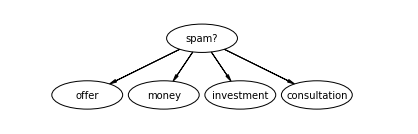

In [4]:
import examples.pgm_diagram_example

examples.pgm_diagram_example.run()